In [5]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as pgo
import wmfdata as wmf
from wmfdata.utils import (
    insert_code_toggle,
    pct_str
)

import nshahquinn as nsq

In [6]:
nsq.set_plotly_defaults()

In [7]:
# Used to remove partial results for the latest day
TODAY = "20230329"

story_edit = wmf.mariadb.run(f"""
    WITH story_page AS (
        SELECT 
            page_id,
            page_title
        FROM page
        WHERE
            page_namespace = 1704
    ),
    story_edit AS (
        SELECT
            rev_timestamp AS dt,
            rev_id AS rev_id,
            actor_name AS user_name,
            REPLACE(page_title, '_', ' ') AS story_title,
            IF(rev_parent_id = 0, 'create new story', 'edit existing story') AS edit_type,
            'live' AS page_status
        FROM story_page
        LEFT JOIN revision
        ON page_id = rev_page
        LEFT JOIN actor
        ON rev_actor = actor_id
        
        UNION
        
        SELECT
            ar_timestamp AS dt,
            ar_rev_id AS rev_id,
            actor_name AS user_name,
            REPLACE(ar_title, '_', ' ') AS story_title,
            IF(ar_parent_id = 0, 'create new story', 'edit existing story') AS edit_type,
            'deleted' AS page_status
        FROM archive
        LEFT JOIN actor
        ON ar_actor = actor_id
        WHERE
            ar_namespace = 1704
            
    ),
    story_user AS (
        SELECT
            user_name,
            min(rev_id) AS first_story_edit
        FROM story_edit
        GROUP BY user_name
    ),
    user_registration AS (
        SELECT
            su.user_name,
            user_registration
        FROM story_user su
        LEFT JOIN user u
        ON su.user_name = u.user_name
    )
    SELECT 
        dt,
        rev_id,
        se.user_name,
        user_registration,
        story_title,
        edit_type,
        rev_id = first_story_edit AS is_user_first_edit,
        page_status
    FROM story_edit se
    LEFT JOIN story_user su
    ON se.user_name = su.user_name
    LEFT JOIN user_registration ur
    ON se.user_name = ur.user_name
    WHERE
        -- For some reason, there is a single story revision from January
        dt >= '20220630'
        AND dt < '{TODAY}'
    ORDER BY dt
    """,
    "idwiki",
    date_col=["dt", "user_registration"]
).assign(
    is_user_first_edit=lambda df: df["is_user_first_edit"].astype(bool)
)

/home/neilpquinn-wmf/.conda/envs/2022-11-30T20.59.36_neilpquinn-wmf/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [8]:
week = pd.to_timedelta('7 days')
today = pd.to_datetime(TODAY)

edit_lag_completed = (today - story_edit["dt"]) > week

story_creation = story_edit.query("edit_type == 'create new story' and @edit_lag_completed")

deletion_rate = len(story_creation.query("page_status == 'deleted'")) / len(story_creation)

print(f"Story deletion rate (7 day lag): {pct_str(deletion_rate)}")

Story deletion rate (7 day lag): 1.1%


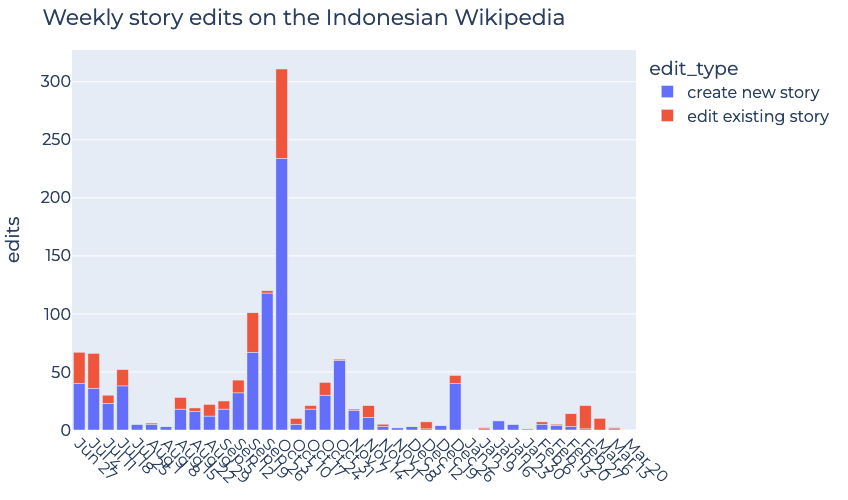

In [15]:
# Weirdly, "W-SUN" here means a week *ending* on Sunday
current_week_start = pd.Timestamp.now().to_period(freq="W-SUN").start_time

week_starts = (
    pd.period_range(
        start=story_edit["dt"].min(),
        end=TODAY,
        freq="W-SUN"
    ).start_time
)

index = pd.MultiIndex.from_product(
    iterables=[
        week_starts,
        ["create new story", "edit existing story"]
    ],
    names=["dt", "edit_type"]
)

weekly_edit = (
    story_edit.groupby([
        # But "W-MON" here means a week *starting* on Monday
        # It seems to make sense to other people (https://stackoverflow.com/q/56954507), but not to me
        pd.Grouper(key="dt", freq="W-MON", label="left"),
        "edit_type"
    ]).aggregate(
        edits=("dt", len)
    ).reindex(index)
    .fillna(0)
    .applymap(int)
    .reset_index()
    # Exclude the current, partial week
    .query("dt < @current_week_start")
)

fig = px.bar(
    weekly_edit,
    x="dt",
    y="edits",
    color="edit_type",
    title="Weekly story edits on the Indonesian Wikipedia",
    height=500
)

week = weekly_edit["dt"].drop_duplicates()
week_text = [w.strftime('%b %-d') for w in week]

fig.update_xaxes(
    tickangle=45,
    title_text=None,
    tickvals=week,
    ticktext=week_text
)

fig.show()

In [16]:
(
    weekly_edit
    .pivot_table(
        index="dt",
        columns="edit_type"
    )
    .droplevel(0, axis="columns")
    [["create new story", "edit existing story"]]
    .tail(5)
)

edit_type,create new story,edit existing story
dt,,
2023-02-20,3,11
2023-02-27,1,20
2023-03-06,0,10
2023-03-13,1,1
2023-03-20,0,0


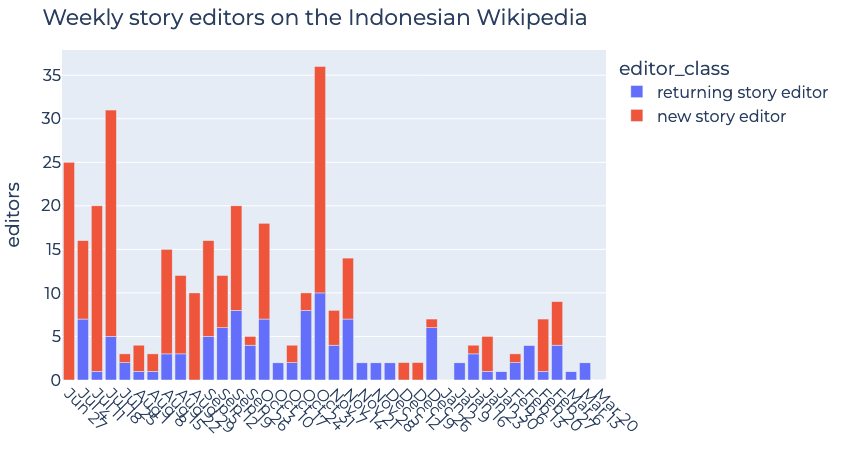

In [17]:
def classify_editor(df):
    if df["is_user_first_edit"].any():
        return "new story editor"
    else:
        return "returning story editor"

index = pd.MultiIndex.from_product(
    iterables=[
        week_starts,
        ["returning story editor", "new story editor"]
    ],
    names=["dt", "editor_class"]
)

weekly_editor = (
    story_edit.groupby([
        pd.Grouper(key="dt", freq="W-MON", label="left"),
        "user_name"
    ]).apply(classify_editor)
    .reset_index()
    .rename(columns={0: "editor_class"})
    .groupby([
        "dt",
        "editor_class"
    ]).agg(editors=("user_name", len))
    .reindex(index)
    .fillna(0)
    .applymap(int)
    .reset_index()
    # Exclude the current, partial week
    .query("dt < @current_week_start")
)

fig = px.bar(
    weekly_editor,
    x="dt",
    y="editors",
    color="editor_class",
    title="Weekly story editors on the Indonesian Wikipedia",
    height=450
)

fig.update_xaxes(
    tickangle=45,
    title_text=None,
    tickvals=week,
    ticktext=week_text
)

fig.show()

In [18]:
(
    weekly_editor
    .pivot_table(
        index="dt",
        columns="editor_class"
    )
    .droplevel(0, axis="columns")
    [["returning story editor", "new story editor"]]
    .tail(5)
)

editor_class,returning story editor,new story editor
dt,,
2023-02-20,1,6
2023-02-27,4,5
2023-03-06,1,0
2023-03-13,2,0
2023-03-20,0,0


# Generate editors list

In [19]:
def unique_days(s):
    return s.dt.round(freq="D").nunique()

def stories_created(df):
    return df.query("edit_type == 'create new story'")["story_title"].nunique()
    

agg_1 = (
    story_edit
    .groupby("user_name")
    .agg(
        days_active=("dt", unique_days),
        story_edits=("dt", len),
        stories_created_or_edited=("story_title", "nunique"),
        registration_date=("user_registration", "min")
    )
)

agg_2 = (
    story_edit
    .groupby("user_name")
    .apply(stories_created)
    .rename("stories_created")
)

story_user = (
    agg_1
    .join(agg_2)
    [["days_active", "story_edits", "stories_created_or_edited", "stories_created", "registration_date"]]
    .assign(registration_date=lambda df: df["registration_date"].fillna("before 2007"))
    .sort_values(["days_active", "story_edits"], ascending=False)
)

In [20]:
story_user.to_csv("data/story_users.csv")